# การทำนายลักษณะกลุ่มโรคของพืช โดยใช้ Plant Disease Model

&emsp;&emsp;&emsp;
ตัวอย่างนี้จะเป็นการทำนายลักษณะกลุ่มโรคของพืช (Plant Disease) จากรูปภาพใบไม้ ซึ่งขั้นตอนการนำภาพถ่ายมาผ่านโปรแกรมทำนายลักษณะกลุ่มโรคของพืชได้สรุปเอาไว้ 4 ขั้นตอน ดังนี้

**ขั้นตอนที่ 1** นำเข้าและเตรียมชุดรูปภาพสำหรับเทรนโมเดล<br>

**ขั้นตอนที่ 2** การเทรนโมเดล<br>

**ขั้นตอนที่ 3** ทำนายลักษณะกลุ่มโรคของพืชผ่านโมเดลที่เตรียมไว้<br>

Number of images: 1200
Number of classes: 4



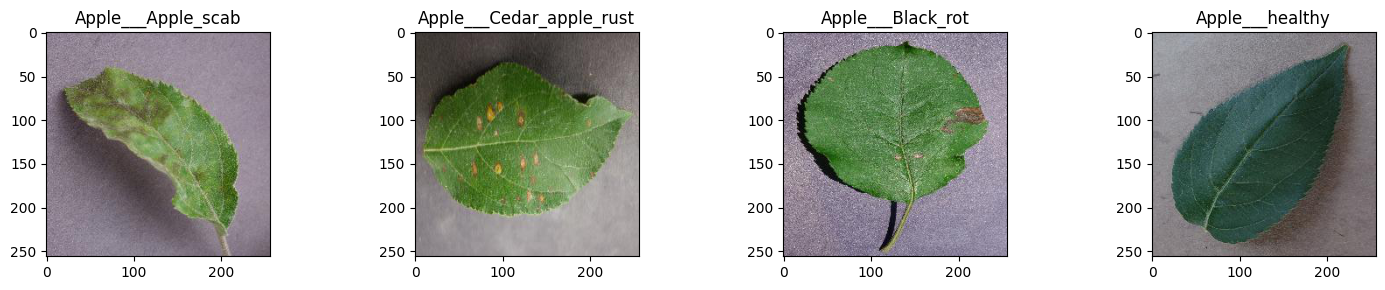

In [5]:
#@title **ขั้นตอนที่ 1** นำเข้าและเตรียมชุดรูปภาพสำหรับการเทรนโมเดล
#@markdown &emsp;&emsp;&emsp;เป็นขั้นตอนการเตรียมชุดข้อมูลโดยแยกรูปภาพกับชื่อกลุ่ม สำหรับนำมาใช้ในการเทรนโมเดล<br>
#@markdown สามารถกดรันเพื่อแสดงผลข้อมูลได้เลย โดยประกอบด้วย 4 ชุดข้อมูล ดังต่อไปนี้
#@markdown <ol>1. Apple__Apple_scab<br>
#@markdown 2. Apple__healthy<br>
#@markdown 3. Apple__Black_rot<br>
#@markdown 4. Apple__Cedar_apple_rust<br>
#@markdown <p>* ข้อมูลที่จัดเรียงแล้วจะถูกเก็บในตัวแปรชื่อ <strong>"data"</strong></p>

import os
import subprocess
import time
import zipfile
import cv2
from glob import glob
from skimage import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

# ฟังก์ชั่นสำหรับแตกไฟล์ ZIP
def extract_zip(filepath):
  with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall()

# ฟังก์ชั่นสำหรับดาวน์โหลดข้อมูลจาก GitHub
def run_shell_script():
  # Clone the repository
  subprocess.run(["git", "clone", "https://github.com/hengkp/microbit_ml_examples.git"])

  # Define the function to copy the files
  def getfile(file_name):
      subprocess.run(["cp", "-R", f"microbit_ml_examples/plant disease prediction/{file_name}", file_name])

  # Copy the required files
  filename = "Plant Leaf Disease Dataset.zip"
  getfile(filename)
  extract_zip(filename)

  # Remove the cloned repository
  subprocess.run(["rm", "-rf", "microbit_ml_examples"])


# ฟังก์ชั่นสำหรับนำเข้ารูปภาพและปรับสัดส่วนค่าสี (intensity) ให้อยู่ในช่วง 0 - 1
def load_images(filename):
    img = io.imread(filename)
    img = cv2.resize(img, (64, 64)) # resize to match inputs of model
    img = img / 255.0 # normalize image data
    img = img.astype(np.float32)
    return img

# ฟังก์ชั่นสำหรับนำเข้ารูปภาพและชื่อ labels จากโฟลเดอร์
def load_images_from_folder(folder):
    images = []
    labels = []
    for foldername in glob(os.path.join(folder,"*")):
        for filename in glob(os.path.join(foldername,"*")):
            if filename.endswith('.JPG'):
                # filepath = os.path.join(folder, foldername, filename)
                img = load_images(filename)
                images.append(img)
                labels.append(foldername.split("/")[-1])  # Use folder name as the label .split('/')[-1]
    return images, labels

# นำเข้ารูปภาพและชื่อ class ของแต่ละรูป
run_shell_script()
folder = 'Plant Leaf Disease Dataset/train'
images, labels = load_images_from_folder(folder)

# รวมข้อมูล images และ labels เข้าด้วยกัน
zipped_data = zip(images, labels)

# สร้างตารางข้อมูล
globals()["data"]  = pd.DataFrame(zipped_data, columns=['images', 'labels'])

# แสดงผลจำนวนรูปภาพที่ใช้และกลุ่ม class ทั้งหมด
print("Number of images:",len(labels))
print("Number of classes:",len(np.unique(labels)))
print('')

# แสดงผลรูปตัวอย่างในแต่ละกลุ่ม
folder_names = [ f for f in os.listdir(folder) if not f.startswith(".") ]
fig, axes = plt.subplots(1, len(folder_names), figsize=(15, 3))
for i, folder_name in enumerate(folder_names):
    file_names = os.listdir(os.path.join(folder, folder_name))
    image_path = os.path.join(folder, folder_name, file_names[0])
    image = io.imread(image_path)
    axes[i].imshow(image)
    axes[i].set_title(folder_name)
plt.tight_layout()
plt.show()

In [6]:
#@title **ขั้นตอนที่ 2** การเทรนโมเดล
#@markdown &emsp;&emsp;&emsp;เป็นขั้นตอนการสร้างโมเดลเพื่อจำแนกรายละเอียดของรูปและเทรนโมเดลจากชุดข้อมูลที่เตรียมไว้ โดยมีการแสดงผล Accuracy จากรูปชุดทดสอบ
#@markdown <p>* โมเดลที่ผ่านการเทรนแล้วจะถูกเก็บในตัวแปรชื่อ <strong>"model"</strong></p>

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
import numpy as np
import time
import warnings
from sklearn.exceptions import ConvergenceWarning

# ซ่อนการแจ้งเตือน
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# โครงสร้างของโมเดลที่ใช้ทำนาย
hidden_layers = (100,50)
mlp_model_activation = 'relu'
mlp_model_alpha = 0.001
mlp_model_solver = 'adam'
mlp_model_maxiter = 200
model = MLPClassifier(hidden_layer_sizes=hidden_layers, activation=mlp_model_activation,
                      alpha=mlp_model_alpha, solver=mlp_model_solver,
                      max_iter=mlp_model_maxiter)


# ปรับตัวแปรให้สอดคล้องกับความต้องการของโมเดล
X = np.array(data["images"].to_list()).reshape(len(data["images"]), -1)
y = data["labels"]

# แบ่งข้อมูลสำหรับ training และ testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# เทรนโมเดล
start_time = time.time()
model.fit(X_train, y_train)
end_time = time.time()
execution_time = end_time - start_time
print('Done training.')
print("Execution training time: {:.2f} seconds".format(execution_time))
print('')

# วิเคราะห์ค่าความแม่นยำ (accuracy)
# accuracy = model.score(X_test, y_test)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', np.round(accuracy,2))

Done training.
Execution training time: 31.19 seconds

Accuracy: 0.87


In [2]:
#@title **ขั้นตอนที่ 3** การทำ Cross Validation
#@markdown &emsp;&emsp;&emsp;เป็นขั้นตอนการทดสอบประสิทธิภาพของโมเดล สามารถกดรันเพื่อเริ่มต้นการทำงานได้เลย<br>
#@markdown <font color='red'>\*ข้ามขั้นตอนนี้ เนื่องจาก Google Colab แบบ <strong>Free Version</strong> ไม่สามารถประมวลผลรูปจำนวนมากได้</font>

# from sklearn.model_selection import cross_val_score, cross_validate
# from IPython.display import display

# # ทำ cross validation
# fold_valid = 2
# cv_scores = cross_val_score(model, X, y, cv=fold_valid)
# cv_results = cross_validate(model, X, y, cv=fold_valid, return_estimator=True)

# # Create an empty list to store the results
# results = []

# # Retrieve the parameters and scores for each fold
# for fold_idx, (estimator, score) in enumerate(zip(cv_results['estimator'], cv_results['test_score']), start=1):
#     # Create a dictionary to store the fold results
#     fold_results = {'Fold': fold_idx, 'Score': score}
#     fitted_parameters = {'Layer {}: Parameter {}'.format(i+1, j+1): param.flatten()
#                         for i, param in enumerate(estimator.coefs_) for j in range(param.size)}
#     fold_results.update(fitted_parameters)

#     # Append the fold results to the list
#     results.append(fold_results)

# # Create a data frame from the results
# results_df = pd.DataFrame(results)

# # Calculate the column-wise average
# average_values = results_df.mean()

# # Add the average values as the last row in the DataFrame
# results_df.loc['AVG'] = average_values

# # Reorder the columns to have 'Fold' and 'Score' as the first columns
# results_df = results_df[['Fold', 'Score'] + [col for col in results_df.columns if col not in ['Fold', 'Score']]]

# display(results_df)

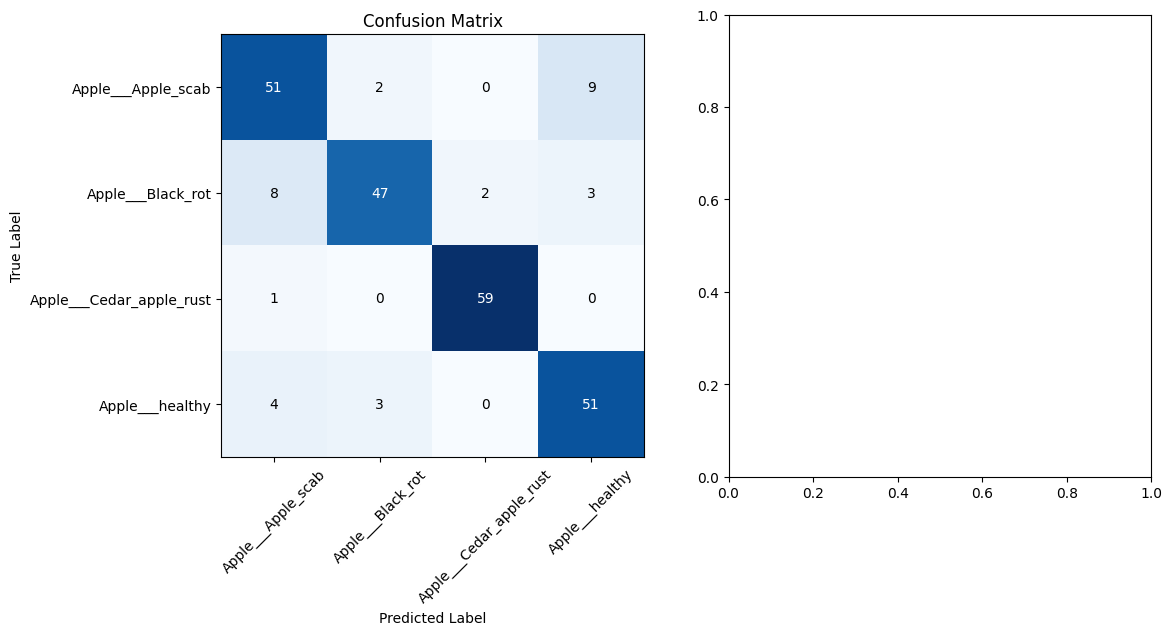

In [15]:
#@title **ขั้นตอนที่ 4** การแสดงผลลัพธ์การเทรนโมเดลในรูปแบบกราฟ
#@markdown &emsp;&emsp;&emsp;เป็นขั้นตอนการแสดงผลประสิทธิภาพของโมเดล สามารถกดรันเพื่อเริ่มต้นการทำงานได้เลย

from sklearn.metrics import confusion_matrix

from matplotlib import pyplot as plt
from matplotlib.table import Table
import numpy as np

# แสดงผลกราฟของชุดข้อมูล
fig, ax = plt.subplots(1, 2, figsize=(12,6))

ylabels = np.unique(y_test)
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
ax[0].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
for i in range(len(ylabels)):
    for j in range(len(ylabels)):
        ax[0].text(j, i, cm[i, j], ha='center', va='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

# กำหนดชื่อแกนในกราฟ
ax[0].set_title('Confusion Matrix')
tick_marks = np.arange(len(ylabels))
ax[0].set_xticks(tick_marks, ylabels, rotation=45)
ax[0].set_yticks(tick_marks, ylabels)
ax[0].set_xlabel('Predicted Label')
ax[0].set_ylabel('True Label')

# # Display 10-fold cross-validation scores
# cv_scores = results_df['Score']
# ax[1].plot(range(1, fold_valid + 1), cv_scores[:-1], marker='o', color='#4CAF50')
# ax[1].set_xlabel('Fold')

# # กำหนดตัวแปรแสดงผลจากชนิดของโมเดล
# ax[1].set_ylabel('Accuracy')
# ax[1].set_title('Cross-Validation for MLP Classification')

# แสดงรูปกราฟ
plt.show()

Labels class: Apple___healthy_1.JPG
Predicted disease: Apple___healthy


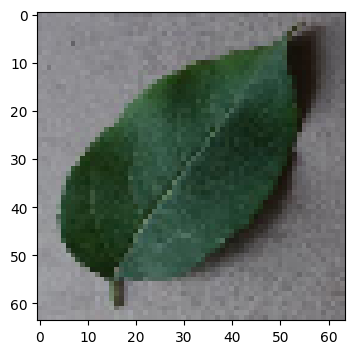

In [19]:
#@title **ขั้นตอนที่ 5** ทำนายลักษณะกลุ่มโรคของพืชผ่านโมเดลที่เตรียมไว้
#@markdown &emsp;&emsp;&emsp;ในขั้นตอนนี้จะเป็นการนำเข้ารูปภาพที่ต้องการทำนายมาทดสอบผ่านโมเดลที่เตรียมไว้

from matplotlib import pyplot as plt

# นำเข้ารูปภาพที่ต้องการทดสอบ
filename = 'Plant Leaf Disease Dataset/test/Apple___healthy_1.JPG'
img = load_images(filename)
img_input = np.array(img).reshape(1, -1)

# ทำนายกลุ่มของรูปภาพที่ต้องการทดสอบ
prediction = model.predict(img_input)
print('Labels class:',filename.split('/')[-1])
print('Predicted disease:', prediction[0])

# แสดงตัวอย่างภาพ
fig = plt.figure(figsize=(4, 4)) # define size of figure
plt.imshow(img) # display image in the figure
plt.show()

\* ไฟล์เนื้อหาทั้งหมดรวมถึงโมเดลและชุดข้อมูลสำหรับการทำนายลักษณะกลุ่มโรคของพืชนี้ สามารถเข้าไปศึกษาเพิ่มเติมและดาวน์โหลดได้ที่[ https://github.com/hengkp/microbit_ml_examples](https://github.com/hengkp/microbit_ml_examples/tree/main/microgreens%20growth%20prediction)